In [1]:
import pandas as pd
from pandas.io.json import json_normalize
from pymongo import MongoClient
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats  
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import json
from bson.json_util import dumps
import urllib.parse

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [25]:
MONGODB_HOST = pd.read_csv('./database/auth')['host'][0]
username = urllib.parse.quote_plus(pd.read_csv('./database/auth')['username'][0])
password = urllib.parse.quote_plus(pd.read_csv('./database/auth')['password'][0])
conn = MongoClient('mongodb://%s:%s@%s' % (username, password, MONGODB_HOST))

conn.database_names()

SyntaxError: invalid syntax (<ipython-input-25-a0b81d6289c8>, line 1)

# NCUx

### NCUx - Freshman calculas

In [3]:
db = conn['KU']
collection_list = db.collection_names()

coll_list = [x for x in collection_list if 'QuizScore' in x]
coll_list

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  


['Course_34451e8c77_QuizScore',
 'Course_792efa2c1b_QuizScore',
 'Course_dbed6c966a_QuizScore',
 'Course_86066cba6d_QuizScore',
 'Course_60ab104927_QuizScore',
 'Course_6b1900c56c_QuizScore',
 'Course_65bb6224af_QuizScore',
 'Course_39a67f80f4_QuizScore',
 'Course_9a683161f5_QuizScore',
 'Course_24a65f29b6_QuizScore']

In [4]:
xmin, xmax = 60, 100
lnspc = np.linspace(xmin, xmax, 100)

arr_score = []
arr_pdf = []
for x in range(0, len(coll_list)):
    
    score_df = pd.DataFrame(list(db[coll_list[x]].find()))['score'].astype(int)
    m, s = stats.norm.fit(score_df)  
    
    score_pdf = stats.norm.pdf(lnspc, m, s)
    arr_pdf.append(score_pdf)
    
    ratio = format(len(score_df[score_df < 80]) / len(score_df[score_df >= 80]), '.2f')
    print(coll_list[x], ratio)

Course_34451e8c77_QuizScore 0.36
Course_792efa2c1b_QuizScore 0.27
Course_dbed6c966a_QuizScore 0.49
Course_86066cba6d_QuizScore 0.05
Course_60ab104927_QuizScore 0.20
Course_6b1900c56c_QuizScore 0.19
Course_65bb6224af_QuizScore 0.45
Course_39a67f80f4_QuizScore 0.26
Course_9a683161f5_QuizScore 0.13
Course_24a65f29b6_QuizScore 0.91


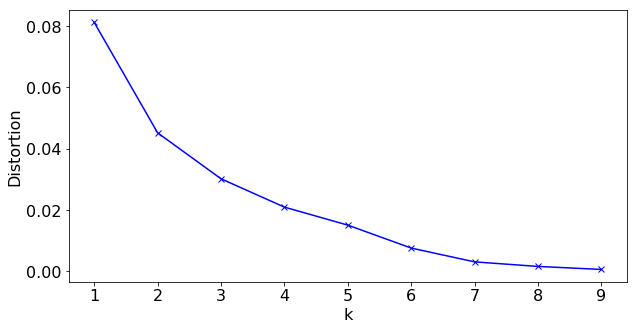

In [5]:
X = np.array(arr_pdf)
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 5))

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

lablestring = 'optimal value for k'
#plt.annotate(lablestring, xy=(3, 0.05), xytext=(3, 0.08),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            )
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
#plt.savefig('./images/elbow.png', dpi=300)
plt.show()

In [6]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
labels

array([1, 2, 1, 0, 2, 2, 1, 2, 0, 1], dtype=int32)

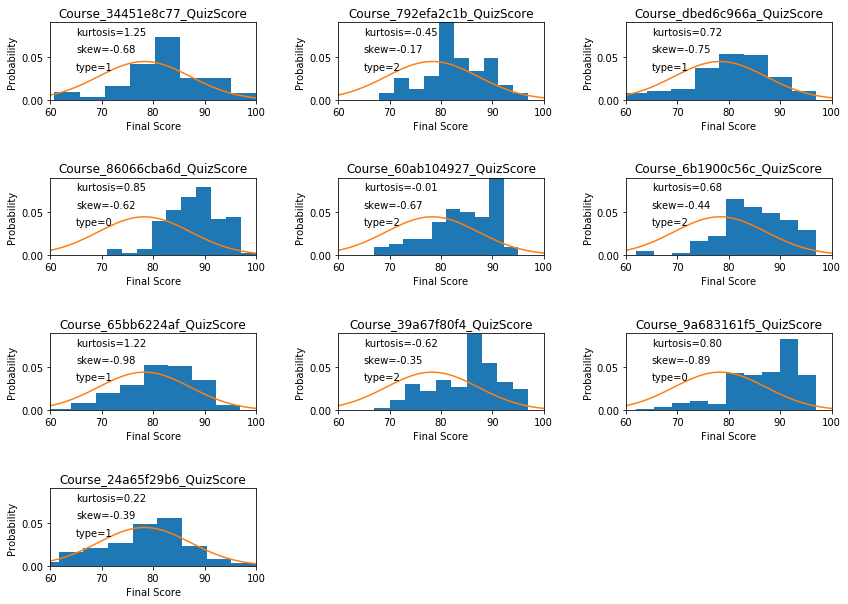

In [7]:

matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace=1, wspace=0.4)

label = ['Validation', 'Testing']
bins = 10
ylimit = 0.09
subplot_x = 4
subplot_y = 3

for x in range(0, len(coll_list)):
    score_df = pd.DataFrame(list(db[coll_list[x]].find()))['score'].astype(int)

    ax = plt.subplot(subplot_x, subplot_y, x+1)
    plt.hist(score_df, bins = bins, density=True)
    plt.plot(lnspc, score_pdf, label="Norm") # plot it
    plt.title(coll_list[x])
    plt.ylabel('Probability')
    plt.xlabel('Final Score')
    plt.xlim(xmin, xmax)
    plt.ylim(0, ylimit)
    
    ax.annotate('kurtosis=' + str(format(kurtosis(score_df), '.2f')), xy=(65, 0.075))
    ax.annotate('skew=' + str(format(skew(score_df), '.2f')), xy=(65, 0.055))
    ax.annotate('type=' + str(labels[x]), xy=(65, 0.035))

In [8]:
len(score_df[score_df < 60])

3